In [5]:
!pip install imutils

import os
import re
import cv2
import math

import numpy as np
import matplotlib.pyplot as plt
import importlib

import itertools
import random

# files
import utils
import synteticDS
# import dataset 

Defaulting to user installation because normal site-packages is not writeable


In [90]:
# Load the dataset

train_data_path= "../../data/all/"
circle_img_paths=[]
blob_img_paths=[]
# shard_img_paths=[]
fibers_img_paths=[]
all_img_paths=[]
# for root, dirs, files in os.walk(train_data_path, topdown=False):
root, dirs, files = next(os.walk(train_data_path))
for dirTemp in dirs:
#     print(dirTemp)
    dirTemp=os.path.join(root, dirTemp)
    for  roott, dirss, files in os.walk(dirTemp):
        for name in files:
    #         if re.findall('particleCutouts.*.jpg', root+name): 
            if re.findall('.jpg', roott+name):  
                imgPath = os.path.join(roott,name)
                if re.findall('cracks', imgPath):
                    fibers_img_paths.append(imgPath) 
                elif re.findall('rBlobs', imgPath):
                    blob_img_paths.append(imgPath)        
                elif re.findall('rCircles', imgPath):
                    circle_img_paths.append(imgPath)    
        break
all_img_paths.append(fibers_img_paths) 
all_img_paths.append(blob_img_paths) 
all_img_paths.append(circle_img_paths)
if not all_img_paths:
    print("err loading ",train_data_path)
else:  
    print("fibers ",len(fibers_img_paths))
    print("blobs ",len(blob_img_paths))    
    print("circles ",len(circle_img_paths))  

blobs  356
fibers  536
circles  321


In [91]:

import random
from imutils import rotate_bound
from random import randint, shuffle

def generate_image(particle_examples, numberOfParticles = 20, background=None, shape=(1080,1920,3), img_config=None):
# particle_examples = path to cutouts of particles
    segMasks = []
    
    if background is None:
        generated_image = np.zeros(shape, dtype=np.uint8)
    else:
        generated_image = copy.deepcopy(background)
        shape=background.shape
        
    for particleClass in particle_examples:
        segMask= np.zeros(shape[:-1], dtype=np.uint8)
#         classMask.append(img)
        for particleClassExample in particleClass:
            particleImg = cv2.imread(particleClassExample)

            image0s = np.zeros(shape, dtype=np.uint8)

#             for i in range(numberOfParticles):
#                 particleImg = cv2.imread(particleClassExample[i]) 
                
            if (np.array(particleImg.shape) > np.array(shape)).any():
                print(np.array(particleImg.shape), np.array(shape))
                continue #skip particles bigger than background


            angle = randint(0, 359)
            rotatedImage = rotate_bound( particleImg, angle)
            ri_rows, ri_cols, _ = rotatedImage.shape
            if (shape[0]-ri_rows)<0:
                print("Rotated img ",particle_examples[i])
                print(" bigger than bckg shouldnt happen, check particle imgs")
                rotatedImage=rotatedImage[ri_rows-shape[0]:,ri_cols-shape[1]:]
                ri_rows, ri_cols, _ = rotatedImage.shape

            row = randint(0, shape[0]-ri_rows)
            col = randint(0, shape[1]-ri_cols)

            image0s[row:row +ri_rows, col:col+ri_cols, :] = rotatedImage
#             particleMask = utils.getMask(image0s,threshold=1,kernelSize=1) 
            
#             print(image0s.shape)
#             print(segMask.shape,particleMask.shape)
            
            particleMask = (image0s > 1 )
            particleMask = image0s[:,:,0] # take only 1 channel
            segMask=(cv2.bitwise_or(segMask,particleMask))

            rotatedImageBG=generated_image[row:row +ri_rows, col:col+ri_cols, :]
            addedRotatedImage = cv2.addWeighted(rotatedImageBG,1,rotatedImage,1,0)

            generated_image[row:row +ri_rows, col:col+ri_cols, :] =  addedRotatedImage    
        segMasks.append(segMask)
        
    segMasks=np.array(segMasks)
    segMasks=np.transpose(segMasks, (1,2,0))

    return [generated_image, segMasks]


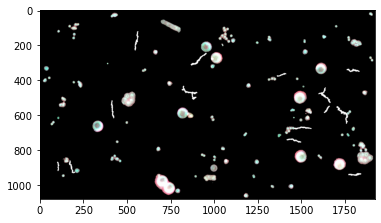

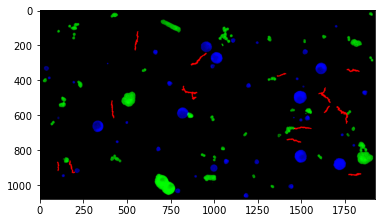

CPU times: user 1min 39s, sys: 2.27 s, total: 1min 41s
Wall time: 1min 41s


In [98]:
%%time
import copy 
importlib.reload(synteticDS)

def splitNumberBy(number,ratio):
    numOfParts=sum(ratio)
    return [round((number/numOfParts)*div) for div in ratio]

# train_data_path= all_img_paths
savePath ="../../data/syn/"
# #  all_img_paths= "../../data/imgs/artificial/* "
# imgBackupParticlesPaths= all_img_paths
# imgWaferParticlesPaths= synteticDS.getPaths("../../data/imgs/artificial/waferCracks_Particles/",False)

# imgWaferPaths= synteticDS.getPaths("../../data/imgs/wafer/in/")
# randomWaferPaths = random.choices(imgWaferPaths, k=70)
# background = synteticDS.backgroundFrameMean(randomWaferPaths,125)
# imgPaths=  list(itertools.chain.from_iterable(allImgPaths)) 

# numberOfParticlesInImg= 10  #randint(0, 50)
for numberOfParticlesInImg in range(10,100):
    ratio=[1,3,3]
    nParticlesOfClass= splitNumberBy(numberOfParticlesInImg,ratio)

    for i in range(5):
        
        allImgPaths=[]
        for idx, dataset in enumerate(all_img_paths): # same ratios of particle types
            randomParticlePaths = random.choices(dataset, k=nParticlesOfClass[idx])
            allImgPaths.append(randomParticlePaths)
        particle_examples = allImgPaths

        generated_image, segMasks = generate_image(particle_examples, numberOfParticlesInImg)

    #     genImg,_ = synteticDS.generate_image(particle_examples, numberOfParticlesInImg)
    ##     genImg = cv2.cvtColor(genImg, cv2.COLOR_BGR2GRAY)
        savePathIN= os.path.join(savePath,"IN/",str(numberOfParticlesInImg)+"particles_"+str(i))
        cv2.imwrite(savePathIN+".jpg", generated_image)

        savePathGT= os.path.join(savePath,"GT/",str(numberOfParticlesInImg)+"particles_"+str(i))
        cv2.imwrite(savePathGT+".tif", segMasks)
    
plt.imshow(generated_image)
plt.show()  
plt.imshow(segMasks)
plt.show()  

In [7]:
# https://www.kaggle.com/code/chanduanilkumar/adding-and-removing-image-noise-in-python
def gauss(image):
    gauss_noise=np.zeros((image.shape[:-1]),dtype=np.uint8)
    cv2.randn(gauss_noise,125,50)
    gauss_noise=(gauss_noise*0.5).astype(np.uint8)
    gauss_noise = cv2.cvtColor(gauss_noise, cv2.COLOR_GRAY2BGR)
    return cv2.add(img,gauss_noise)

def uniform(image):
    uni_noise=np.zeros((image.shape[:-1]),dtype=np.uint8)
    cv2.randu(uni_noise,0,255)
    uni_noise=(uni_noise*0.5).astype(np.uint8)
    uni_noise = cv2.cvtColor(uni_noise, cv2.COLOR_GRAY2BGR)
    return cv2.add(img,uni_noise)

def impulse(image,ratio=0.5): # (salt and pepper)
    imp_noise=np.zeros((image.shape[:-1]),dtype=np.uint8)
    cv2.randu(imp_noise,0,255)
    imp_noise=cv2.threshold(imp_noise,int(255*ratio),255,cv2.THRESH_BINARY)[1]
    imp_noise = cv2.cvtColor(imp_noise, cv2.COLOR_GRAY2BGR)
    return cv2.add(image,imp_noise)

def getNoise(image, noiseType, arguments=None):
    if noiseType.lower()=="g" or noiseType.lower()=="gauss":
        image=gauss(image)
    elif noiseType.lower()=="u" or noiseType.lower()=="uniform":
        image=uniform(image)
    elif noiseType.lower()=="i" or noiseType.lower()=="impulse" or noiseType.lower()=="s&p":
        image=impulse(image)
    return image


In [13]:
import torchvision
from torchvision import datasets, transforms
import numpy as np


aug_transform = transforms.Compose([
    transforms.RandomAffine(degrees=(30, 70),
#                             translate=(0.1, 0.3), 
                            scale=(0.75, 1.25)),
    transforms.GaussianBlur(kernel_size=(5,5), sigma=(1, 5)),
#     transforms.ToTensor(),
])

augPath = "../../data/syn/test/temp/"
dataset = datasets.ImageFolder(augPath)
# aug_dataset = datasets.ImageFolder(augPath, aug_transform)
print(len(dataset))
for idx,image in enumerate(dataset):
    img=np.array(image[0])
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    gaussImg= gauss(img)
    uniImg= uniform(img)
    s_n_pImg= impulse(img,0.75)
    
#     print(dataset.imgs[idx][0])
    
#     plt.imshow(img)
#     plt.show() 
#     plt.imshow(gaussImg)
#     plt.show()  
#     plt.imshow(uniImg)
#     plt.show()  
#     plt.imshow(s_n_pImg)
#     plt.show()  
    filePath=os.path.join(os.path.dirname(dataset.imgs[idx][0]),"noised")
    fileName=os.path.basename(dataset.imgs[idx][0])
#     print(os.path.join(filePath,"../gauss"+fileName))
#     break
    cv2.imwrite(os.path.join(augPath,"../gray",fileName), img)
    cv2.imwrite(os.path.join(augPath,"../gauss",fileName), gaussImg)
    cv2.imwrite(os.path.join(augPath,"../uniform",fileName), uniImg)
    cv2.imwrite(os.path.join(augPath,"../salt",fileName), s_n_pImg)

450


In [66]:
# TODO segMaskCombine


In [ ]:
# TODO masks to coco
# TODO segMaskCombine
# save (cocoView, segMaskCombine, genImage) -> send to F,A,E



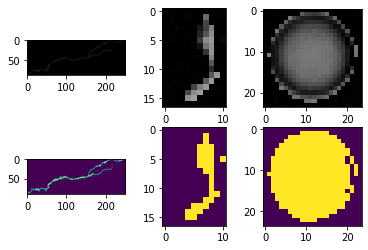

(89, 250, 3)


In [4]:
# fig, axarr = plt.subplots(2,3)

# for idx, classList in enumerate(all_img_paths):
#     image = cv2.imread(classList[0])
#     imageMask = utils.getMask(image,threshold=4,kernelSize=1) 
#     # listContours = markContours(imageMask) 
# #     imgContours = utils.img2segmented(imageMask)
    
# #     axarr[idx].imshow(imgContours)
#     axarr[0][idx].imshow(image)
#     axarr[1][idx].imshow(imageMask)
    
# plt.show()
# #     a=np.unique(imgContours)
# print(cv2.imread(fibers_img_paths[0]).shape)

2 (2, 5) (2, 2)


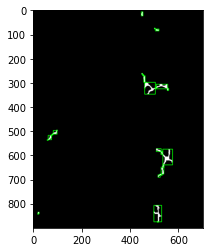

In [82]:
image = cv2.imread(all_img_paths[0][0])
imageMask = utils.getMask(image,threshold=100,kernelSize=10) 
contours = cv2.findContours(imageMask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # img, contours, hierarchy

labelsCount, _, values, centroids=  cv2.connectedComponentsWithStats(imageMask) 
print(labelsCount, values.shape, centroids.shape)

contoursImg = np.zeros(image.shape, dtype=np.uint8)
axSize = math.sqrt(labelsCount)
fig, axarr = plt.subplots(1,3)

for i,cnt in enumerate(contours[0]): # iterate through contours
    if i > 0:  # skip background
        contour = cnt.squeeze()
        """ coco features """
#         image0 = np.zeros(image.shape, dtype=np.uint8)

        moments = cv2.moments(contour)
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])
        
        BBox = cv2.boundingRect(contour)  # cv2.rectangle(contoursImg,(BBox[0],BBox[1]),(BBox[0]+BBox[2],BBox[1]+BBox[3]),(0,255,0),2)
        area = cv2.contourArea(contour)
        
        cv2.rectangle(contoursImg,(BBox[0],BBox[1]),(BBox[0]+BBox[2],BBox[1]+BBox[3]),(0,255,0),2)
        contoursImg = cv2.drawContours(contoursImg, contours[0],i,(255,255,255), thickness=cv2.FILLED)


plt.imshow(contoursImg)
plt.show()
    

# plot_intensity_histogram(image) 

In [ ]:
if ( h/w ratio >x || <x) || contour length/convex hull ratio